# Identificação de motoristas através de comportamentos de condução

##  Imports

In [25]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from heapq import heappush, heappop

## Gerando dados sintéticos de comportamentos de condução para 10 motoristas

In [3]:
# Configurações
num_motoristas = 10
segundos_por_motorista = 86400  # 1 dia de dados por motorista
total_linhas = num_motoristas * segundos_por_motorista

# Função para gerar dados sintéticos para um motorista
def gerar_dados_motorista(motorista_id, n_registros):
    np.random.seed(motorista_id)  # manter reprodutibilidade por motorista

    # Simula variações realistas por motorista
    velocidade_base = random.uniform(40, 100)
    aceleracao_base = random.uniform(-1, 1)
    rotacao_base = random.uniform(1000, 3000)
    consumo_base = random.uniform(8, 15)

    dados = {
        'motorista_id': [motorista_id] * n_registros,
        'timestamp': pd.date_range("2025-04-10 00:00:00", periods=n_registros, freq='S'),
        'velocidade_kmh': np.clip(np.random.normal(velocidade_base, 10, n_registros), 0, 180),
        'aceleracao_ms2': np.clip(np.random.normal(aceleracao_base, 0.5, n_registros), -3, 3),
        'rpm': np.clip(np.random.normal(rotacao_base, 300, n_registros), 500, 6000),
        'consumo_l_100km': np.clip(np.random.normal(consumo_base, 1.0, n_registros), 5, 25),
        'angulo_volante_graus': np.clip(np.random.normal(0, 30, n_registros), -180, 180),
        'posicao_pedal_acelerador': np.clip(np.random.normal(30, 20, n_registros), 0, 100),
        'freio_acionado': np.random.choice([0, 1], size=n_registros, p=[0.85, 0.15]),
        'marcha': np.random.choice(range(1, 7), size=n_registros),
        'gps_inclinacao': np.clip(np.random.normal(0, 3, n_registros), -10, 10),
        'gps_curva_graus': np.clip(np.random.normal(0, 20, n_registros), -180, 180)
    }

    return pd.DataFrame(dados)

## Salvando arquivo em .csv

## Lendo arquivo com dados sintéticos gerado

### Visualizando as primeiras linhas do conjunto de dados

In [4]:
df = pd.read_csv('../data/raw/dados_obd_sinteticos.csv')
df.head()

,motorista_id,timestamp,velocidade_kmh,aceleracao_ms2,rpm,consumo_l_100km,angulo_volante_graus,posicao_pedal_acelerador,freio_acionado,marcha,gps_inclinacao,gps_curva_graus
0,0,2025-04-10 00:00:00,87.641492,-1.164779,2856.580894,12.974922,-3.010104,49.875534,0,4,6.412683,19.300237
1,0,2025-04-10 00:00:01,74.002541,-0.248364,3077.701709,13.668439,33.277285,61.205832,0,1,2.937810,-11.193276
2,0,2025-04-10 00:00:02,79.788349,-0.921159,2830.124124,13.328252,-12.179117,7.030715,0,3,3.128054,5.762080
3,0,2025-04-10 00:00:03,92.409901,-0.880992,2645.434835,14.942527,48.682247,24.472256,0,6,-2.114854,7.320182
4,0,2025-04-10 00:00:04,88.676549,-0.618572,2639.916381,14.947222,30.107772,29.852586,0,5,-2.536785,-9.340282


## Análise Exploratória (EDA)

### Verificando colunas dos dados

In [5]:
df.columns

Index(['motorista_id', 'timestamp', 'velocidade_kmh', 'aceleracao_ms2', 'rpm',
       'consumo_l_100km', 'angulo_volante_graus', 'posicao_pedal_acelerador',
       'freio_acionado', 'marcha', 'gps_inclinacao', 'gps_curva_graus'],
      dtype='object')

### Verificando tamanho do conjunto de dados

In [6]:
df.shape

(864000, 12)

### Verificando a existência de dados nulos

In [7]:
df.isna().sum()

motorista_id                0
timestamp                   0
velocidade_kmh              0
aceleracao_ms2              0
rpm                         0
consumo_l_100km             0
angulo_volante_graus        0
posicao_pedal_acelerador    0
freio_acionado              0
marcha                      0
gps_inclinacao              0
gps_curva_graus             0
dtype: int64

### Verificando os tipos de dados de cada coluna

In [8]:
df.dtypes

motorista_id                  int64
timestamp                    object
velocidade_kmh              float64
aceleracao_ms2              float64
rpm                         float64
consumo_l_100km             float64
angulo_volante_graus        float64
posicao_pedal_acelerador    float64
freio_acionado                int64
marcha                        int64
gps_inclinacao              float64
gps_curva_graus             float64
dtype: object

### Verificando a quantidade de motoristas

In [9]:
df.motorista_id.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Realizando análise de distribuição das variáveis abaixo com uma amostra de dados para cada motorista: 

Para evitar sobrecarga de memória e visualizações densas demais devido ao alto volume de dados, optamos por utilizar **amostras aleatórias dos dados por motorista**. A análise a seguir mostra a distribuição das seguintes variáveis:

- `velocidade_kmh`  
- `aceleracao_ms2`  
- `rpm`  
- `consumo_l_100km`  
- `angulo_volante_graus`  
- `posicao_pedal_acelerador`  
- `marcha`  
- `gps_inclinacao`  
- `gps_curva_graus`  

As distribuições serão analisadas por meio de histogramas, gráficos de densidade (KDE) e boxplots. Essas abordagens facilitam a interpretação dos padrões de condução individuais e ajudam a identificar possíveis diferenças entre os motoristas com base em seu estilo de direção.


#### Obtendo amostra

In [10]:
def driver_samples(df, size):
    list_dataframes_samples = []
    for i in range(10):
        print('ID_Motorista:', i)
        df_driver = df[df.motorista_id == i]
        df_driver_sample = df_driver.sample(size, random_state=42)
        list_dataframes_samples.append(df_driver_sample)
    return pd.concat(list_dataframes_samples)

def plots_histogram_analysis(sample, array_variables_dataset, count_subplots):
    # Criar subplots em 1 linha e n(count_subplots) colunas
    fig, axs = plt.subplots(1, count_subplots, figsize=(24, 5))  # Largura total aumentada
    
    # Plotar cada histograma
    for i, var in enumerate(array_variables_dataset):
        sns.histplot(sample[var], bins=50, kde=True, ax=axs[i], color='skyblue')
        axs[i].set_title(var)
        axs[i].set_xlabel(var)
        axs[i].set_ylabel('Frequência')
    
    plt.tight_layout()
    plt.show()

In [11]:
dv_samples = driver_samples(df, 10000)

ID_Motorista: 0
ID_Motorista: 1
ID_Motorista: 2
ID_Motorista: 3
ID_Motorista: 4
ID_Motorista: 5
ID_Motorista: 6
ID_Motorista: 7
ID_Motorista: 8
ID_Motorista: 9


In [12]:
dv_samples.head()

,motorista_id,timestamp,velocidade_kmh,aceleracao_ms2,rpm,consumo_l_100km,angulo_volante_graus,posicao_pedal_acelerador,freio_acionado,marcha,gps_inclinacao,gps_curva_graus
43404,0,2025-04-10 12:03:24,45.945584,-1.254292,3073.382390,13.554596,33.345751,25.230675,0,5,-4.624741,18.646467
78317,0,2025-04-10 21:45:17,63.047813,-0.486870,3159.726750,14.766736,31.056006,5.048942,0,5,1.594952,5.139402
6096,0,2025-04-10 01:41:36,76.780529,-0.628180,2982.387154,15.088523,-58.204085,0.000000,0,5,-0.036797,4.100237
40929,0,2025-04-10 11:22:09,73.633072,-0.680562,2862.234306,14.693674,13.893542,43.944134,0,3,-0.942629,17.686829
59505,0,2025-04-10 16:31:45,63.349937,-1.014227,2917.690892,15.495757,-1.488069,27.196232,0,6,-0.616065,-10.608583


#### Verificando distribuição dos dados na variáveis de comportamento de condução para cada motorista

ID Motorista: 0


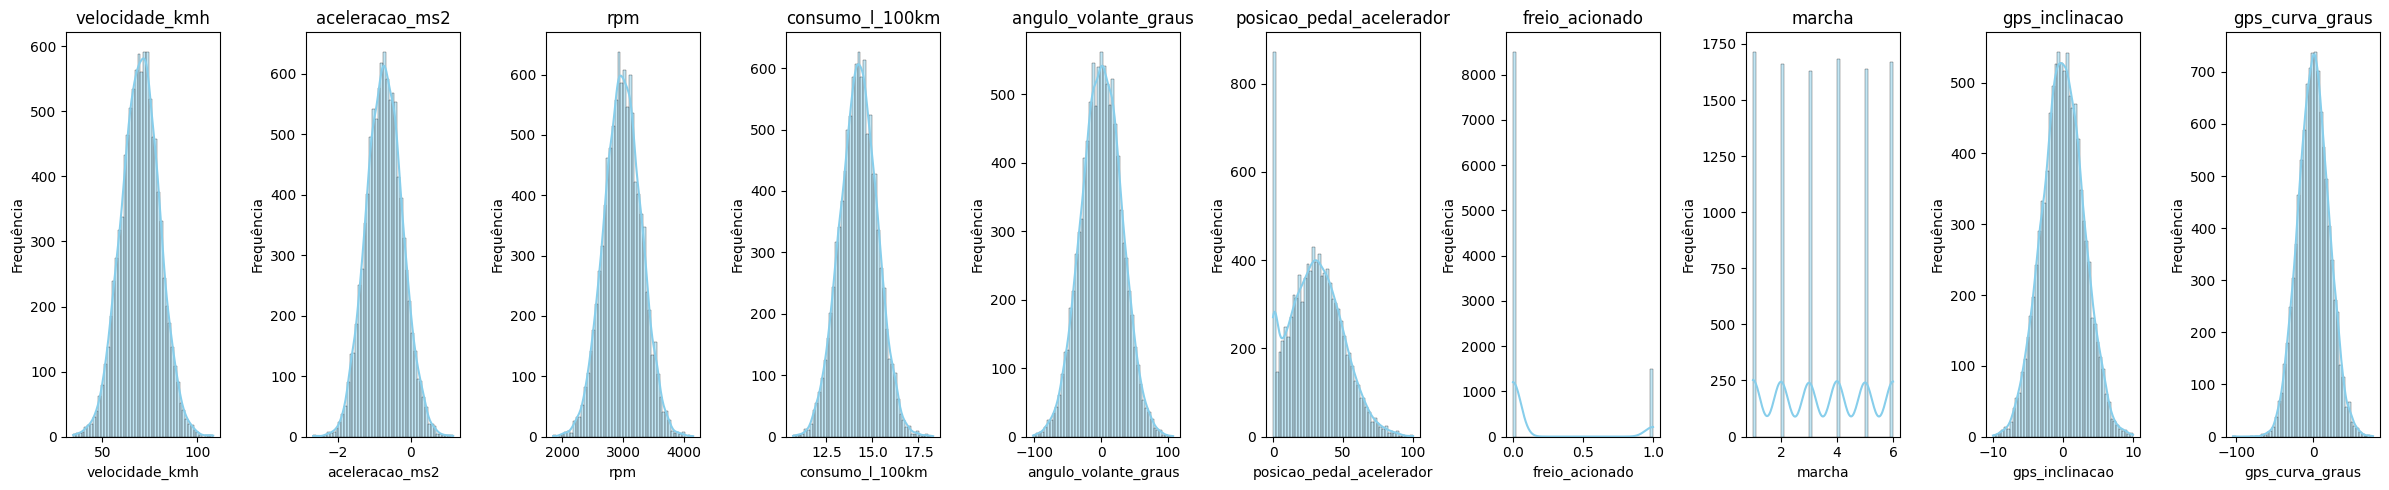

ID Motorista: 1


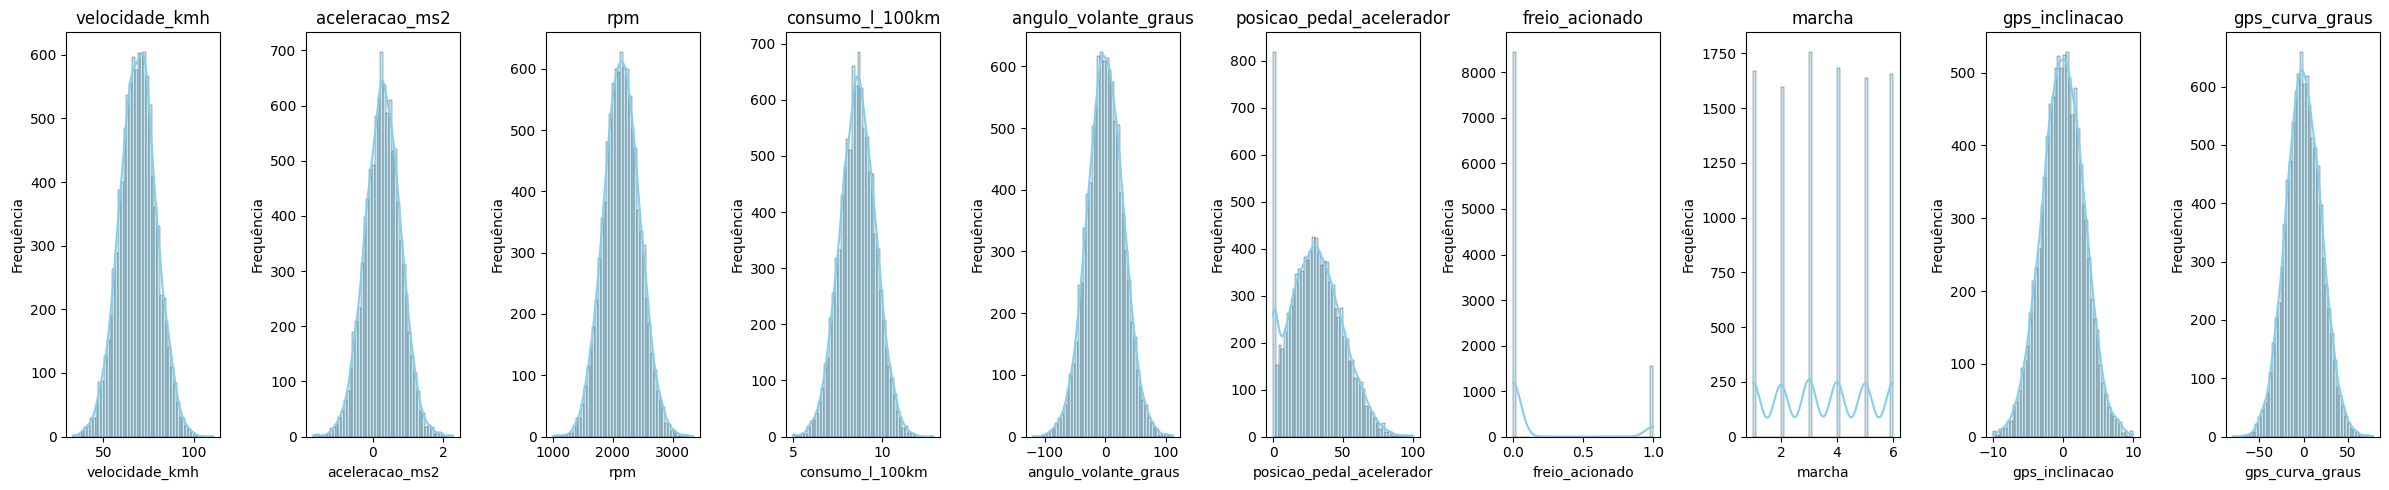

ID Motorista: 2


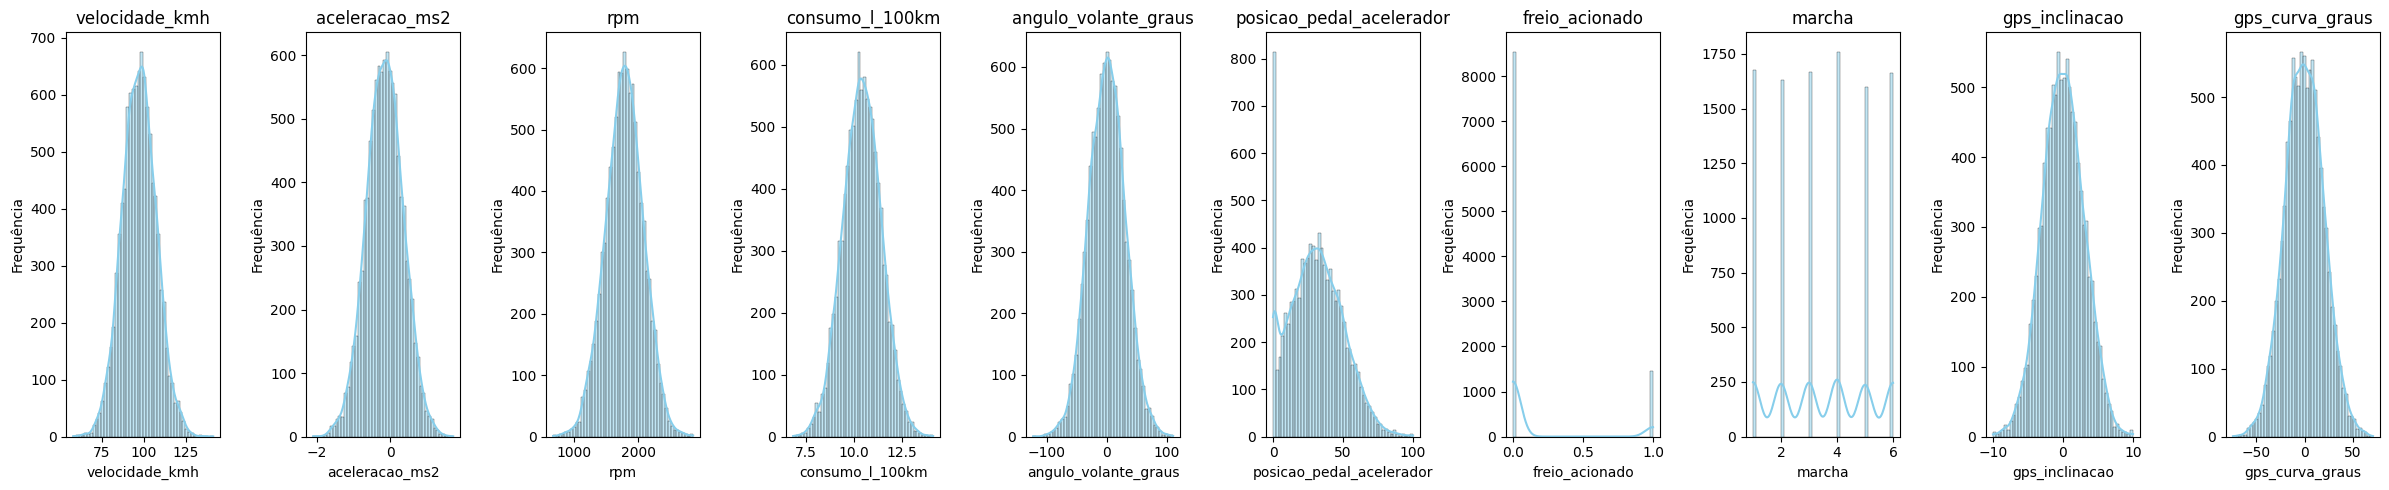

ID Motorista: 3


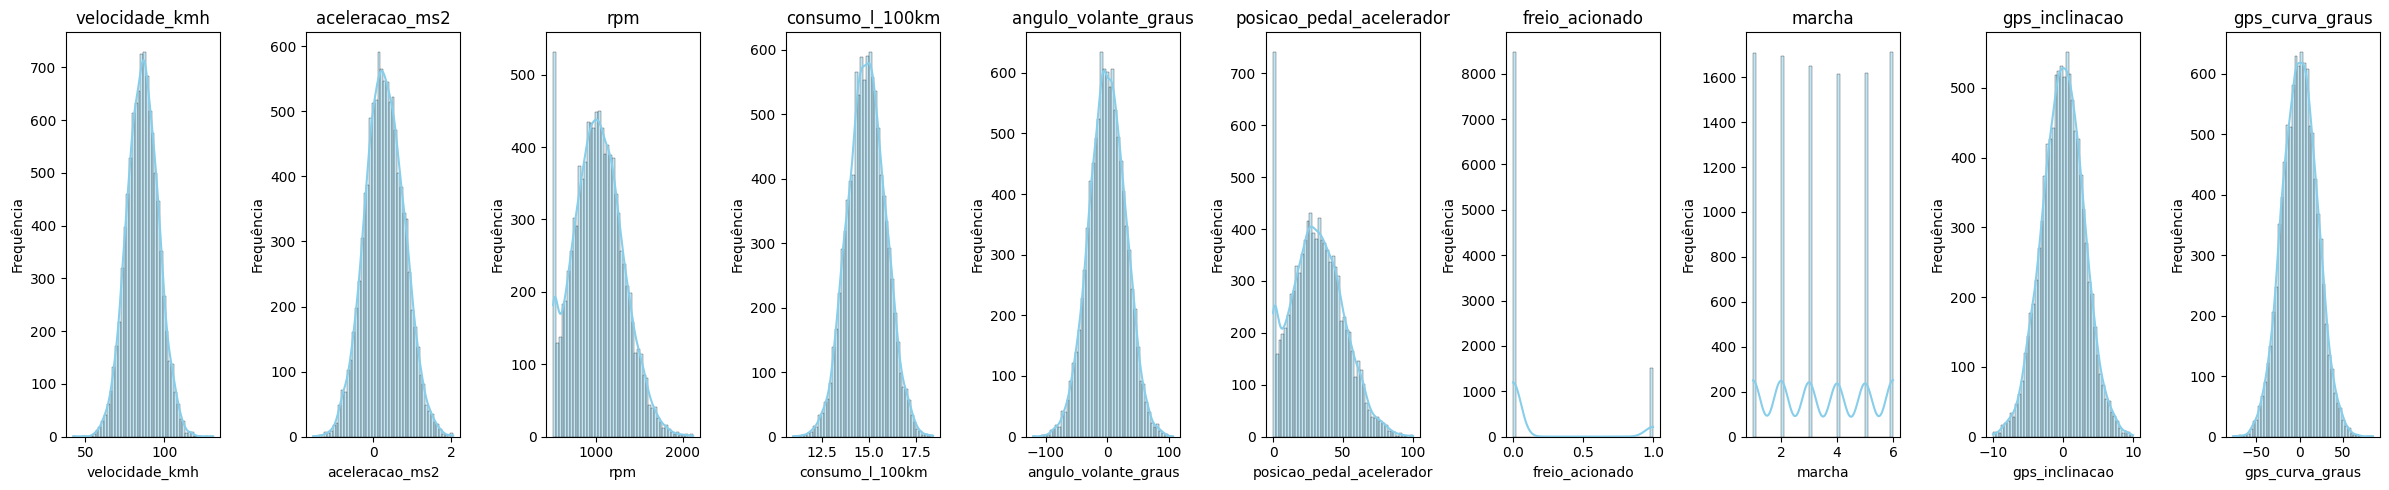

ID Motorista: 4


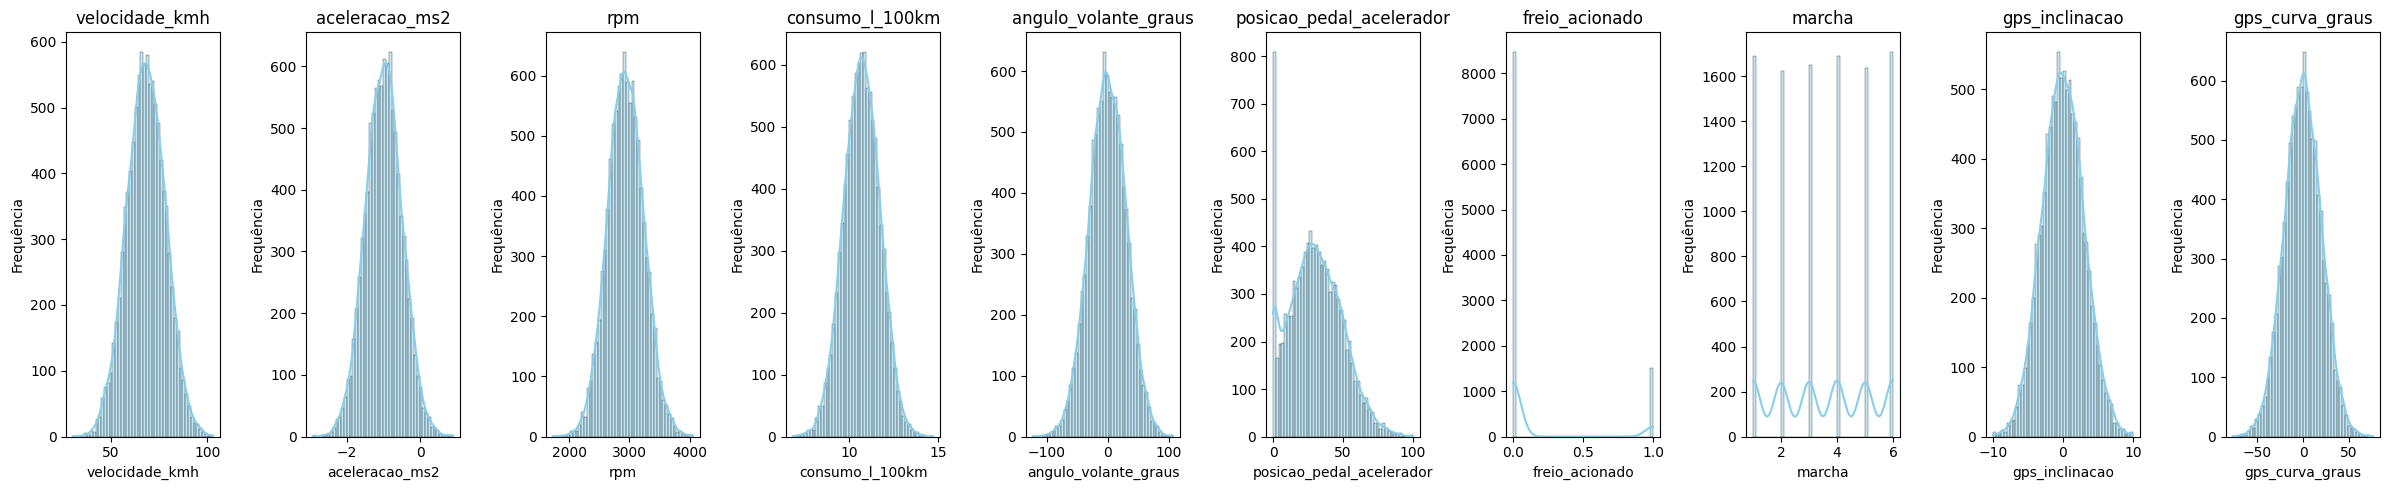

ID Motorista: 5


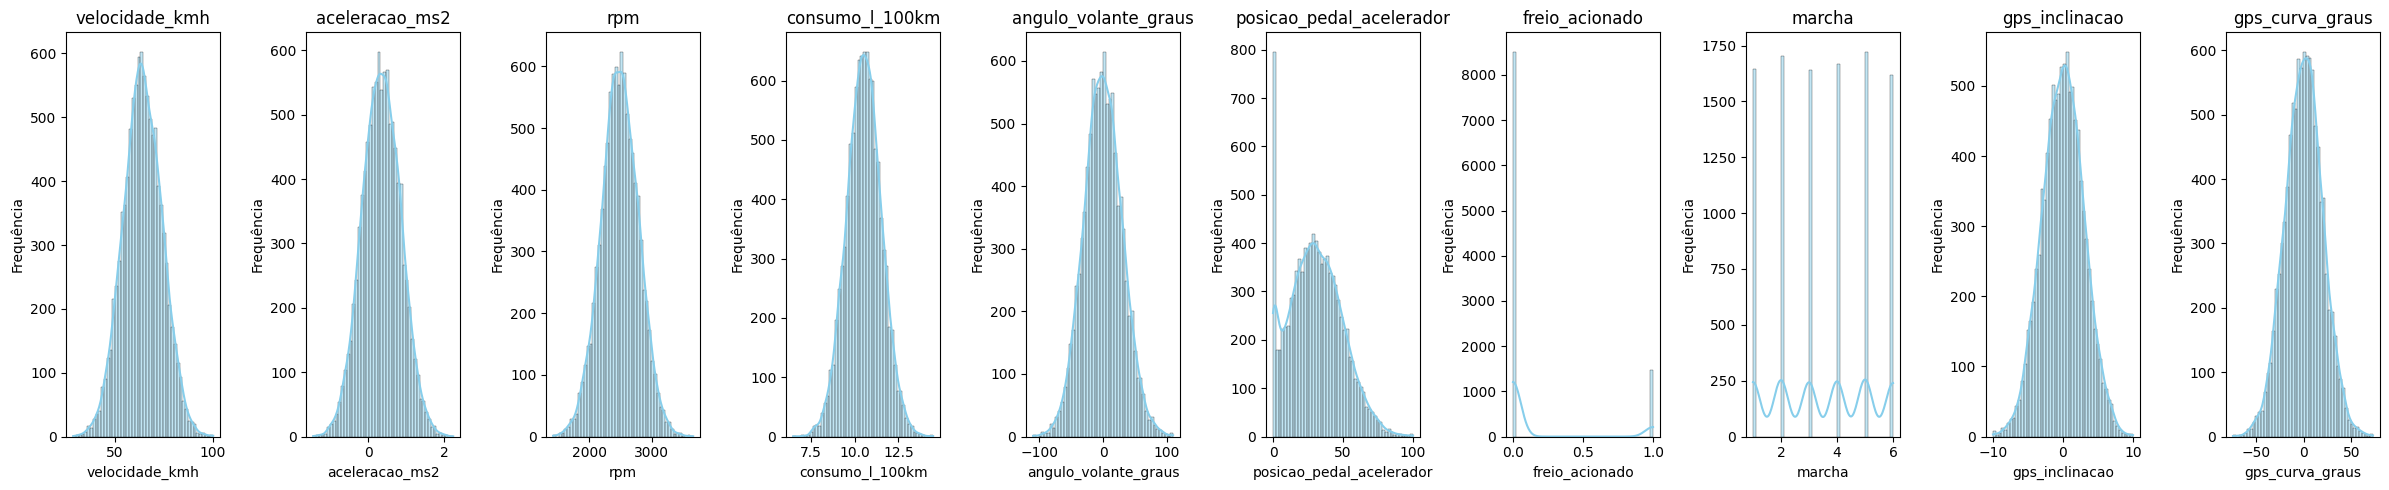

ID Motorista: 6


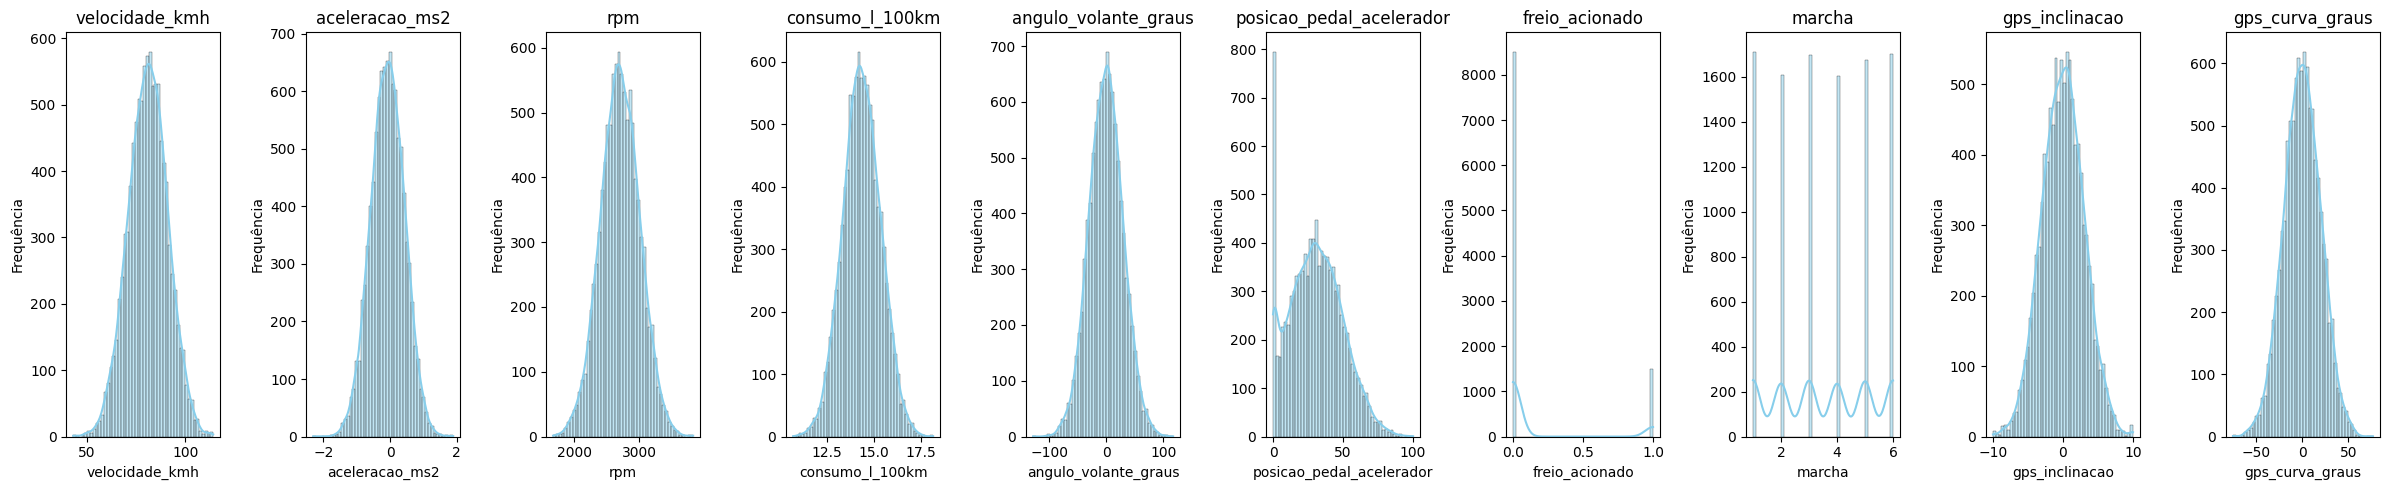

ID Motorista: 7


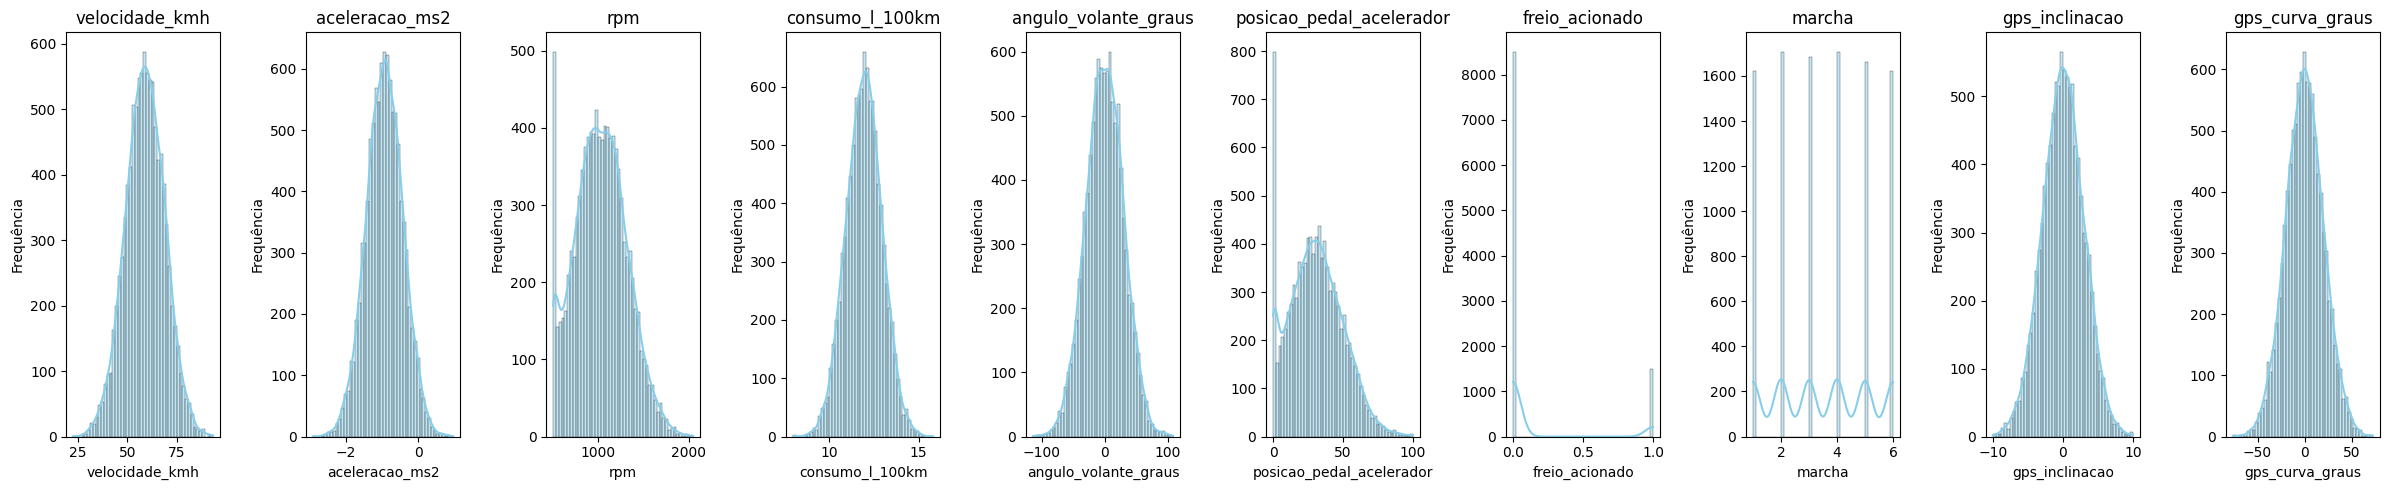

ID Motorista: 8


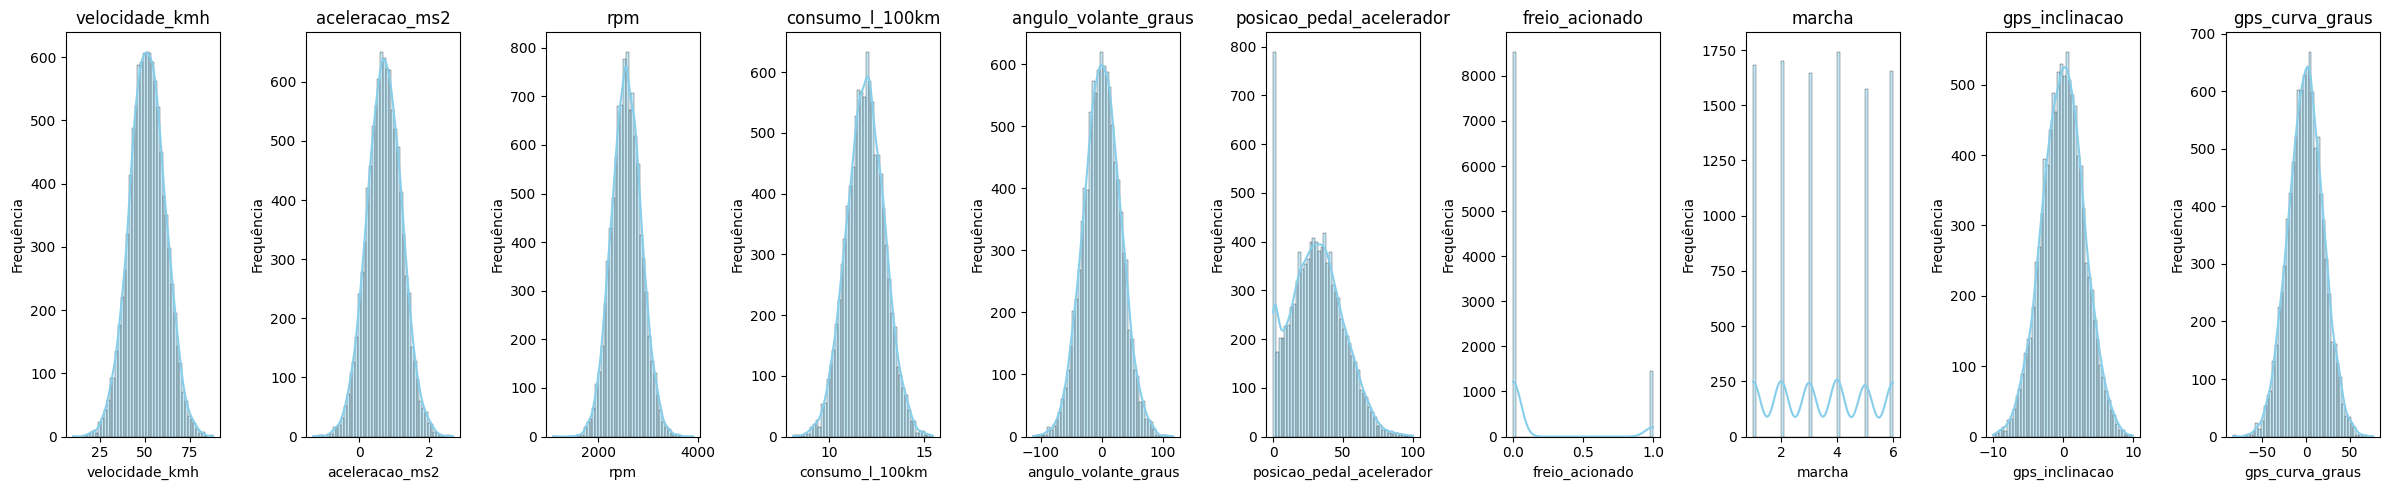

ID Motorista: 9


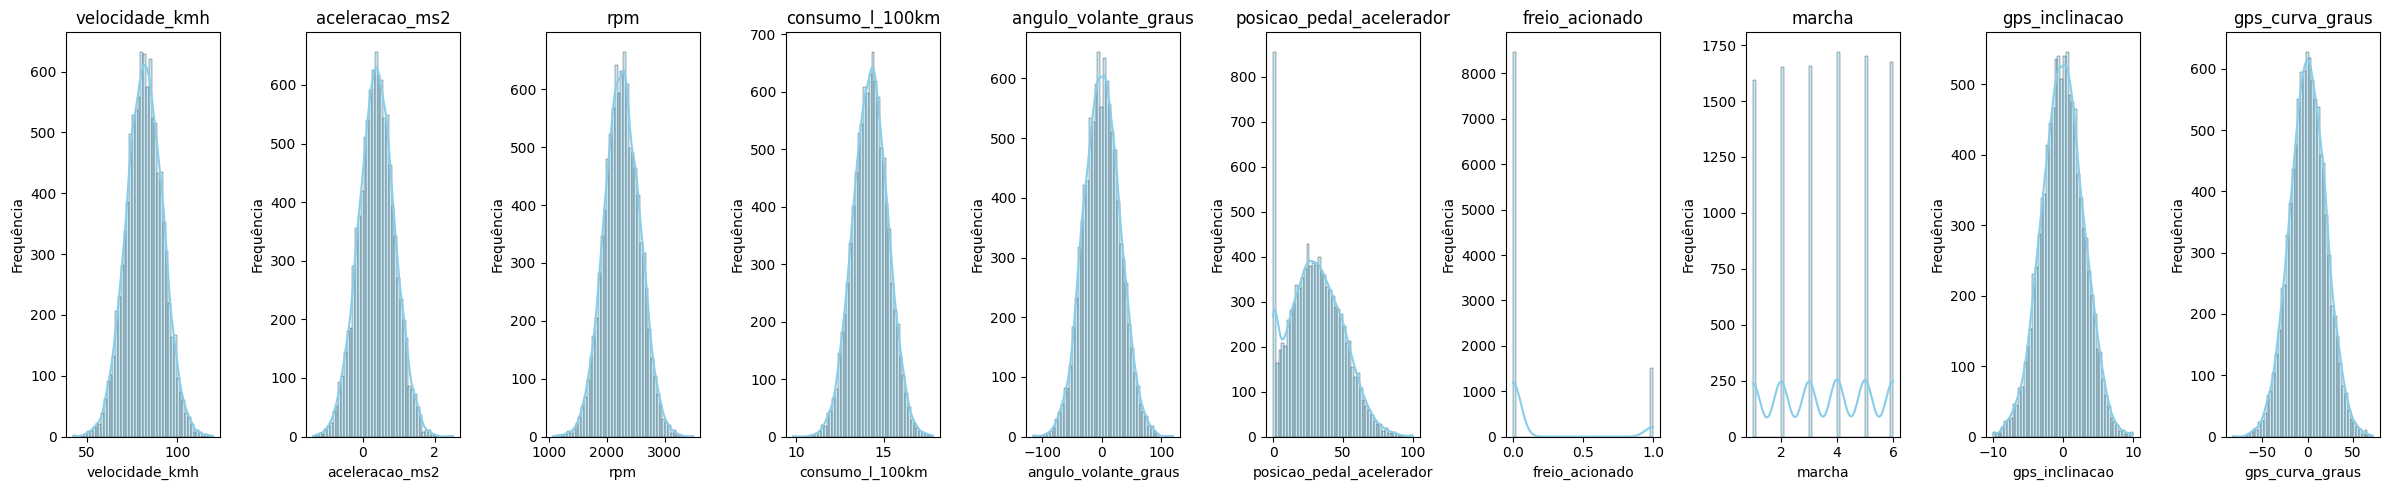

In [13]:
dataset_variables_analysis = dv_samples.columns[2:]
drivers = dv_samples.motorista_id.unique()

for driver in drivers:
    sample_driver_id = dv_samples[dv_samples.motorista_id == driver]
    print('ID Motorista:', driver)
    plots_histogram_analysis(sample_driver_id, dataset_variables_analysis, len(dataset_variables_analysis))

### Calculando estatísticas para cada motoristas:

In [14]:
for driver in drivers:
    sample_driver_id = dv_samples[dv_samples.motorista_id == driver]
    print('\nID Motorista:', driver)
    print(sample_driver_id.describe().loc[['mean', '50%', 'std']])
    print('\n')


ID Motorista: 0
      motorista_id  velocidade_kmh  aceleracao_ms2          rpm  \
mean           0.0       69.998788       -0.723833  2990.607372   
50%            0.0       70.114081       -0.727288  2989.237189   
std            0.0       10.006879        0.498182   303.251707   

      consumo_l_100km  angulo_volante_graus  posicao_pedal_acelerador  \
mean        14.247350              0.581942                 30.279321   
50%         14.255816              0.862156                 29.793517   
std          1.009954             30.061479                 18.876863   

      freio_acionado    marcha  gps_inclinacao  gps_curva_graus  
mean        0.149300  3.487700       -0.029158         0.233473  
50%         0.000000  3.000000       -0.038250         0.216599  
std         0.356402  1.715268        2.980697        20.048655  



ID Motorista: 1
      motorista_id  velocidade_kmh  aceleracao_ms2          rpm  \
mean           1.0       69.011158        0.290106  2152.598724   
50% 


### Análise Estatística das Variáveis por Motorista: Teste de Krustal

Para verificar se motoristas apresentam padrões estatísticos diferentes em relação às variáveis coletadas, aplicamos o **teste de Kruskal-Wallis**, que é um teste estatístico não paramétrico indicado quando não podemos assumir que os dados seguem uma distribuição normal.

Este teste avalia se há diferenças estatísticas significativas entre os grupos (neste caso, os 10 motoristas) para cada variável individualmente.

#### ✅ Interpretação do teste:
- **Hipótese nula (H₀):** Todos os motoristas apresentam a mesma distribuição da variável analisada.
- **Hipótese alternativa (H₁):** Pelo menos um motorista possui uma distribuição diferente.

Rejeitamos H₀ quando o **valor p < 0.05**, indicando **diferença estatística significativa**.

#### 📊 Resultados Obtidos:

| **Variável**                | **Estatística** | **p-valor** | **Diferença entre motoristas**  |
|-----------------------------|-----------------|-------------|---------------------------------|
| velocidade_kmh              | 63172.09        | < 0.0001    | ✅ Significativa                |
| aceleracao_ms2              | 57329.83        | < 0.0001    | ✅ Significativa                |
| rpm                         | 79381.64        | < 0.0001    | ✅ Significativa                |
| consumo_l_100km             | 80883.80        | < 0.0001    | ✅ Significativa                |
| posicao_pedal_acelerador    | 20.22           | 0.0166      | ✅ Significativa                |
| angulo_volante_graus        | 9.58            | 0.3852      | ❌ Não significativa            |
| freio_acionado              | 5.12            | 0.8234      | ❌ Não significativa            |
| marcha                      | 6.26            | 0.7136      | ❌ Não significativa            |
| gps_inclinacao              | 5.63            | 0.7760      | ❌ Não significativa            |
| gps_curva_graus             | 14.52           | 0.1051      | ❌ Não significativa            |


- As **variáveis significativas** indicam que os motoristas apresentam padrões distintos de condução. Elas são boas candidatas para:
    - Seleção de atributos em modelos preditivos
    - Identificação de perfis de condução
    - Treinamento de modelos de **classificação** ou **clusterização**

- As **variáveis não significativas** apresentam padrões semelhantes entre os motoristas e, possivelmente, têm **baixo poder discriminativo** para modelos de aprendizado.


In [15]:
for var in dataset_variables_analysis:
    #Montando lista de compação entre motoristas para teste
    groups = [dv_samples[dv_samples['motorista_id'] == i][var] for i in range(10)]
    stat, p = kruskal(*groups)
    resultado = "SIGNIFICATIVA" if p < 0.05 else "não significativa"
    print(f"{var:<30} | Estatística: {stat:>7.2f} | p-valor: {p:.4f} | Diferença: {resultado}")
    

velocidade_kmh                 | Estatística: 63172.09 | p-valor: 0.0000 | Diferença: SIGNIFICATIVA
aceleracao_ms2                 | Estatística: 57329.83 | p-valor: 0.0000 | Diferença: SIGNIFICATIVA
rpm                            | Estatística: 79381.64 | p-valor: 0.0000 | Diferença: SIGNIFICATIVA
consumo_l_100km                | Estatística: 80883.80 | p-valor: 0.0000 | Diferença: SIGNIFICATIVA
angulo_volante_graus           | Estatística:    9.58 | p-valor: 0.3852 | Diferença: não significativa
posicao_pedal_acelerador       | Estatística:   20.22 | p-valor: 0.0166 | Diferença: SIGNIFICATIVA
freio_acionado                 | Estatística:    5.12 | p-valor: 0.8234 | Diferença: não significativa
marcha                         | Estatística:    6.26 | p-valor: 0.7136 | Diferença: não significativa
gps_inclinacao                 | Estatística:    5.63 | p-valor: 0.7760 | Diferença: não significativa
gps_curva_graus                | Estatística:   14.52 | p-valor: 0.1051 | Diferença: não 

### Análise de Correlação entre Variáveis

A matriz de correlação abaixo foi calculada com o objetivo de investigar possíveis relações lineares entre as variáveis analisadas no comportamento dos motoristas.

A **correlação** varia de **-1 a 1**:

- **Valores próximos de 1** indicam **forte correlação positiva**, ou seja, quando uma variável aumenta, a outra tende a aumentar.
- **Valores próximos de -1** indicam **forte correlação negativa**, ou seja, quando uma variável aumenta, a outra tende a diminuir.
- **Valores próximos de 0** indicam **fraca ou nenhuma correlação linear**.

---

#### 📊 Principais observações:

- **velocidade_kmh** apresentou correlação **positiva fraca** com **consumo_l_100km** (**0.18**), sugerindo que velocidades maiores tendem a aumentar levemente o consumo.
- **velocidade_kmh** tem uma correlação **negativa leve** com **rpm** (**-0.17**), indicando que em algumas situações, o aumento de velocidade pode ocorrer com rotação reduzida (possivelmente por trocas de marcha eficientes).
- As demais correlações entre variáveis, como **aceleracao_ms2**, **freio_acionado**, **marcha**, e **sensores de GPS**, apresentam valores **muito próximos de zero**, o que indica que **não há relação linear evidente** entre elas.

---

#### 🧠 Interpretação:

Isso sugere que essas variáveis podem estar mais relacionadas a **padrões comportamentais** ou **contextuais específicos** e não possuem **influência direta entre si de forma linear**.

---

Essa análise é importante para entender como algumas variáveis podem se influenciar e também serve de apoio para **escolhas futuras em modelos de machine learning** ou **análises mais profundas**.


In [16]:
dv_samples[dataset_variables_analysis].corr()

,velocidade_kmh,aceleracao_ms2,rpm,consumo_l_100km,angulo_volante_graus,posicao_pedal_acelerador,freio_acionado,marcha,gps_inclinacao,gps_curva_graus
velocidade_kmh,1.000000,0.024000,-0.173605,0.184193,-0.002807,0.000009,0.000439,0.001094,-0.002238,-0.001087
aceleracao_ms2,0.024000,1.000000,-0.024394,0.002450,-0.000461,0.000838,-0.001165,-0.002321,-0.001165,0.001991
rpm,-0.173605,-0.024394,1.000000,-0.049778,0.000770,-0.009830,-0.001466,0.000742,0.000520,-0.000350
consumo_l_100km,0.184193,0.002450,-0.049778,1.000000,0.002985,0.002040,0.000515,-0.000629,-0.007077,0.005716
angulo_volante_graus,-0.002807,-0.000461,0.000770,0.002985,1.000000,0.000852,0.004681,-0.001955,0.000692,-0.001965
posicao_pedal_acelerador,0.000009,0.000838,-0.009830,0.002040,0.000852,1.000000,-0.002318,-0.002572,0.001502,-0.004607
freio_acionado,0.000439,-0.001165,-0.001466,0.000515,0.004681,-0.002318,1.000000,0.004471,0.003326,0.002042
marcha,0.001094,-0.002321,0.000742,-0.000629,-0.001955,-0.002572,0.004471,1.000000,0.002113,-0.002624
gps_inclinacao,-0.002238,-0.001165,0.000520,-0.007077,0.000692,0.001502,0.003326,0.002113,1.000000,-0.001556
gps_curva_graus,-0.001087,0.001991,-0.000350,0.005716,-0.001965,-0.004607,0.002042,-0.002624,-0.001556,1.000000


### Clusterizando os dados de amostra que geramos com as variáveis mais significativas no teste de Krustal

#### Filtrando dados com as variáveis mais significativas

In [17]:
data_cluster = dv_samples[['velocidade_kmh', 'aceleracao_ms2', 'rpm', 'consumo_l_100km', 'posicao_pedal_acelerador']]
data_cluster.head()

,velocidade_kmh,aceleracao_ms2,rpm,consumo_l_100km,posicao_pedal_acelerador
43404,45.945584,-1.254292,3073.382390,13.554596,25.230675
78317,63.047813,-0.486870,3159.726750,14.766736,5.048942
6096,76.780529,-0.628180,2982.387154,15.088523,0.000000
40929,73.633072,-0.680562,2862.234306,14.693674,43.944134
59505,63.349937,-1.014227,2917.690892,15.495757,27.196232


#### Normalizando dados

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cluster)
X_scaled

array([[-1.63612245, -1.53924937,  1.18659689,  0.60383836, -0.28483801],
       [-0.59529383, -0.52928166,  1.30306785,  1.13901927, -1.35644721],
       [ 0.24046881, -0.71525289,  1.0638523 ,  1.28109386, -1.62453585],
       ...,
       [ 0.03343625,  0.25314894,  0.30502201,  1.00967479,  0.9820644 ],
       [ 0.17176494,  0.78286467, -0.21329746,  0.57590201,  0.44233202],
       [ 0.72797921,  1.26984586, -0.03249071,  1.01161764, -1.56410015]])

#### Clusterizando a amostra com KMeans

In [19]:
# Clusterizando com 10 clusters (número totais de motoristas no conjunto de dados)
mbkmeans = MiniBatchKMeans(n_clusters=10, batch_size=1000, random_state=42)
dv_samples.loc[:, 'cluster'] = mbkmeans.fit_predict(X_scaled)
dv_samples.head()

,motorista_id,timestamp,velocidade_kmh,aceleracao_ms2,rpm,consumo_l_100km,angulo_volante_graus,posicao_pedal_acelerador,freio_acionado,marcha,gps_inclinacao,gps_curva_graus,cluster
43404,0,2025-04-10 12:03:24,45.945584,-1.254292,3073.382390,13.554596,33.345751,25.230675,0,5,-4.624741,18.646467,3
78317,0,2025-04-10 21:45:17,63.047813,-0.486870,3159.726750,14.766736,31.056006,5.048942,0,5,1.594952,5.139402,3
6096,0,2025-04-10 01:41:36,76.780529,-0.628180,2982.387154,15.088523,-58.204085,0.000000,0,5,-0.036797,4.100237,3
40929,0,2025-04-10 11:22:09,73.633072,-0.680562,2862.234306,14.693674,13.893542,43.944134,0,3,-0.942629,17.686829,7
59505,0,2025-04-10 16:31:45,63.349937,-1.014227,2917.690892,15.495757,-1.488069,27.196232,0,6,-0.616065,-10.608583,3


#### Reduzindo a dimensionalidade com PCA

In [20]:
# Redução de dimensionalidade com PCA para 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[-1.55338976, -1.57138455],
       [-0.55219099, -1.6398147 ],
       [ 0.17853727, -1.98575529],
       ...,
       [ 0.44649057,  0.44992599],
       [ 0.62050432,  0.72665827],
       [ 1.13646734, -0.22971415]])

#### Visualizando Clusters

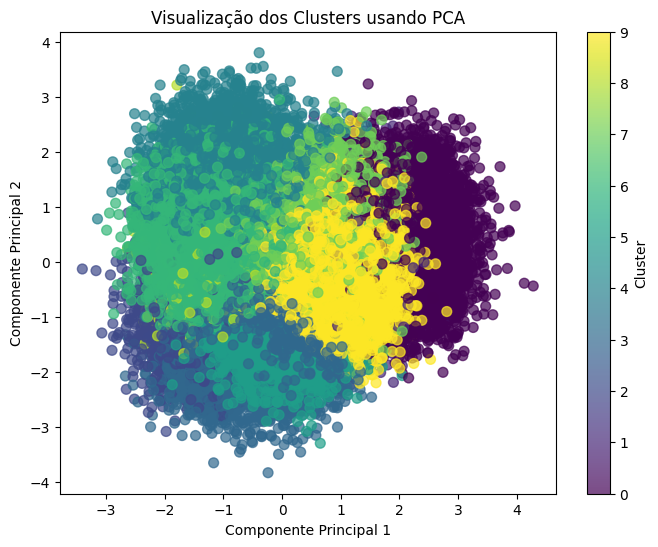

In [21]:
# Cria o gráfico para visualização dos clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dv_samples['cluster'], cmap='viridis', marker='o', s=50, alpha=0.7)
plt.title('Visualização dos Clusters usando PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

### Validação de clusters por motorista

#### 🔥 Distribuição de Clusters por Motorista (Heatmap KMeans)

| 🧍 Motorista | 🧊 Cluster Dominante(s)    | 🧪 Qualidade da Separação  | 📝 Observação                        |
|--------------|----------------------------|----------------------------|--------------------------------------|
| 🚗 0         | 🔷 Cluster 2, 🟦 Cluster 7 | ✅ Razoável                | Boa concentração em 2, presença no 7 |
| 🚗 1         | 🟢 Cluster 8, 🟦 Cluster 4 | 🟡 Média                   | Um pouco espalhado entre 4 e 8       |
| 🚗 2         | 🟡 Cluster 1               | 🟢 Excelente               | Quase totalmente isolado em 1        |
| 🚗 3         | 🔴 Cluster 0               | 🟢 Excelente               | Muito bem separado                   |
| 🚗 4         | 🟢 Cluster 2, 🟦 Cluster 3 | ✅ Boa                     | Maioria em 2, algum ruído em 3       |
| 🚗 5         | 🟦 Clusters 4, 6, 7        | 🟡 Média                   | Disperso entre múltiplos clusters    |
| 🚗 6         | 🟪 Clusters 3, 6, 9        | 🔸 Fraca a Média           | Bastante misturado                   |
| 🚗 7         | 🟣 Cluster 5               | 🟢 Excelente               | Extremamente isolado em 5            |
| 🚗 8         | 🟦 Clusters 4, 6, 8        | ✅ Razoável                | Dividido entre poucos clusters       |
| 🚗 9         | 🟢 Cluster 9, 🟦 Cluster 7 | ✅ Boa                     | Predominância clara em 9             |

---


- 🟢 **Excelente separação:** Motoristas 2, 3, 7  
- ✅ **Boa separação:** Motoristas 0, 4, 8, 9  
- 🟡 **Separação média:** Motoristas 1, 5  
- 🔸 **Separação fraca:** Motorista 6  


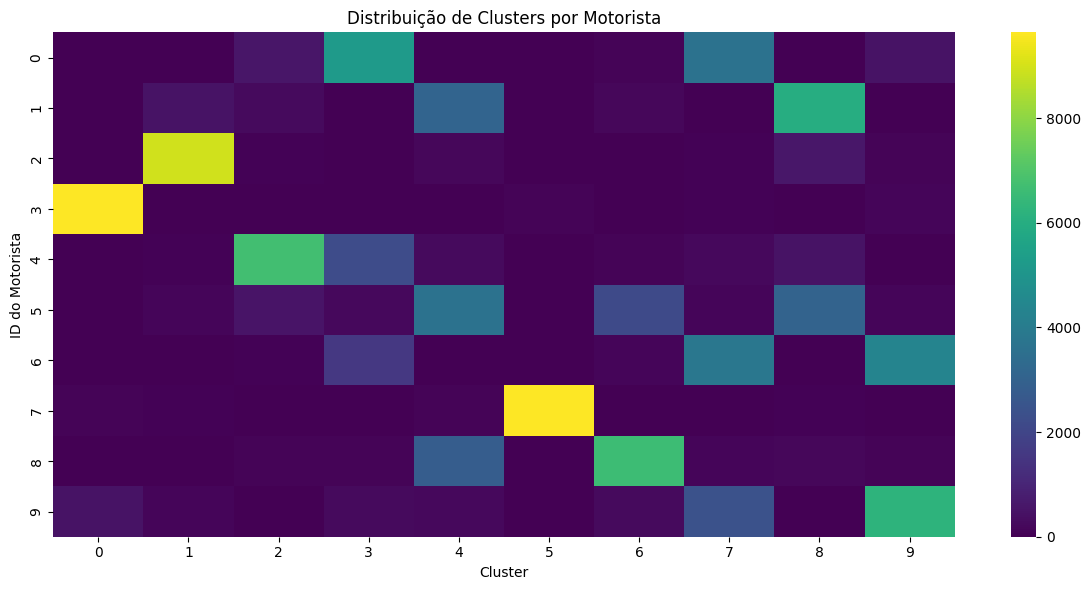

In [22]:
# Contar quantos registros de cada motorista caíram em cada cluster
contagem = dv_samples.groupby(['motorista_id', 'cluster']).size().unstack(fill_value=0)

# Plotar como heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(contagem, cmap='viridis', annot=False, cbar=True)
plt.title("Distribuição de Clusters por Motorista")
plt.xlabel("Cluster")
plt.ylabel("ID do Motorista")
plt.tight_layout()
plt.show()

## ⚡ Extreme Learning Machine (ELM)

O **ELM** é um modelo de aprendizado de máquina para **redes neurais feedforward** com **uma única camada oculta**, conhecido por seu **treinamento extremamente rápido**.

---

### 🧠 Características principais

- 🔸 **Treinamento ultrarrápido**  
  - Os pesos entre a entrada e a camada oculta são **aleatórios e fixos**
  - Apenas os pesos da **camada de saída** são ajustados

- 🔸 **Sem backpropagation**
  - Os pesos são calculados usando **solução analítica** (ex: pseudoinversa de Moore-Penrose)

- 🔸 Boa capacidade de **generalização**

- 🔸 Aplicável para:
  - ✅ Classificação
  - ✅ Regressão
  - ✅ Reconhecimento de padrões

---

### 🧮 Como funciona

1. 🎲 Inicializa pesos aleatórios entre entrada e camada oculta  
2. 🧮 Calcula a saída da camada oculta com função de ativação (ex: sigmoid, ReLU)  
3. 🔁 Calcula pesos da camada de saída com **pseudoinversa**:

   ![equacao1](https://latex.codecogs.com/png.image?\dpi{120}\bg_white\mathbf{H}\beta=\mathbf{T})

   Onde:  
   - **H**: matriz de saída da camada oculta  
   - **β**: pesos da camada de saída  
   - **T**: vetor alvo  

---

### 🛠️ Fórmulas principais

- 📤 Saída da rede:

  ![equacao2](https://latex.codecogs.com/png.image?\dpi{120}\bg_white%20f(x)%20=%20\sum_{i=1}^{L}%20\beta_i%20\cdot%20g(w_i%20\cdot%20x%20+%20b_i))

- 🧮 Cálculo dos pesos de saída:

  ![equcao3](https://latex.codecogs.com/png.image?\dpi{120}\bg_white%20\beta%20=%20H^{\dagger}%20T)

  Onde \( H^T \) é a **pseudoinversa de \( H \)**

---

### ⚖️ Vantagens

- 🚀 Treinamento rápido (ideal para grandes conjuntos de dados)  
- 🔍 Simples de implementar  
- 📈 Boa generalização  

### ⚠️ Desvantagens

- 🎲 Dependência dos **pesos aleatórios**  
- 🧩 Pode exigir muitos neurônios ocultos  
- 🔄 Pouco controle sobre a **estrutura interna**

---

### 📚 Referência

- Huang et al., *Extreme Learning Machine: Theory and Applications*, 2006


In [27]:

class ELM:

    #ELM --> corrigida
    def __init__(self, neurons, activation):
        self.neurons = neurons
        self.activation = activation
        self.W = None
        self.Bi = None

    def fit(self, X, y):
        ne = X.shape[1]
        N = y.shape[0]
        X = np.concatenate([X, np.ones((N, 1))], axis=1)


        self.W = np.random.rand(ne + 1, self.neurons)/10

        Hi = np.dot(X, self.W)

        H = self.activation_function(Hi, self.activation)

        self.Bi = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        N = X.shape[0]
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        Hi = np.dot(X, self.W)
        H = self.activation_function(Hi, self.activation)
        Y = np.dot(H, self.Bi)
        return Y
    
    def activation_function(self, X, activation):
        output = None
        if activation == 'relu':
            output = np.maximum(0, X)

        elif activation == 'sigmoid':
            output = 1./(1 + np.exp(-X))

        elif activation == 'tanh':
            output = np.tanh(X)
        
        elif activation == 'softmax':
            x_exp = np.exp(X - np.max(X, axis=-1, keepdims=True)) 
            output = x_exp / np.sum(x_exp, axis=-1, keepdims=True)

        return output

In [42]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

model = ELM(4, 'tanh')
model.fit(X, y)
model.predict(X)

array([7.10542736e-14, 1.00000000e+00, 1.00000000e+00, 8.52651283e-14])

## 🌲 OPF - Optimum-Path Forest (OPF)

O **OPF** é um algoritmo de **classificação supervisionada** baseado em **teoria de grafos**, onde os exemplos de treino formam um grafo ponderado, e os **protótipos** "atraem" os outros nós por meio de **caminhos ótimos**.

---

### 🔢 Notação

- X = {x₁, x₂, ..., xₙ}: vetores de treino  
- Y = {y₁, y₂, ..., yₙ}: rótulos verdadeiros  
- D(xᵢ, xⱼ): função de distância (ex: Euclidiana)  
- P ⊂ X: conjunto de **protótipos**  
- C(x): custo do caminho ótimo até o nó x  
- P(x): predecessor de x no caminho ótimo  

---

### 🧠 Ideia Central

1. Cada ponto do conjunto de treino é um **nó** em um **grafo ponderado**.
2. Os **pesos das arestas** são dados pela distância D(xᵢ, xⱼ).
3. O algoritmo **propaga caminhos ótimos** a partir dos protótipos para os demais pontos, rotulando-os com base em quem os "conquistou".

---

### ⚙️ Etapas do Algoritmo

#### 1. Construção do Grafo 🌐
- Grafo completo: conecta todos os pares (xᵢ, xⱼ)
- Peso da aresta: D(xᵢ, xⱼ)

#### 2. Seleção de Protótipos 🧩
- Se dois nós adjacentes têm rótulos diferentes, ambos se tornam protótipos.

#### 3. Propagação dos Caminhos Ótimos 🧭
Para cada protótipo p:
- Inicializar: C(p) = 0, label(p) = yₚ
- Para todos os outros nós q:
  - Atualizar:  
    C(q) = minₚ∈P max(C(p), D(p, q))
  - Herdar rótulo e predecessor do protótipo com menor custo.

#### 4. Classificação de Novos Pontos 🔍
Para cada x ∈ X_test:
- Atribuir o rótulo de treino com menor:
  max(C(xᵢ), D(xᵢ, x))

---

### ✅ Vantagens

- 🌲 Não-paramétrico  
- 🧠 Usa todos os dados como grafo  
- 🚀 Muito rápido em predição  
- 🧩 Ótimo para dados com estruturas complexas  

---

### 📚 Referência

- [Falcão, A.X., & Araújo, A. (2004)](https://www.sciencedirect.com/science/article/abs/pii/S0031320304000551)  
  *The Optimum-Path Forest: A Novel Image Classification and Segmentation Algorithm.*

In [26]:
class OPF:
    def __init__(self, distance_fn=None):
        self.distance_fn = distance_fn or self._euclidean

    def _euclidean(self, a, b):
        return np.linalg.norm(a - b)

    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.n = len(X)

        self.cost = np.full(self.n, np.inf)
        self.label = np.full(self.n, -1)
        self.pred = np.full(self.n, -1)
        self.prototype = np.zeros(self.n, dtype=bool)

        # === Etapa 1: encontrar protótipos ===
        self._find_prototypes()

        # === Etapa 2: propagar caminhos ótimos ===
        self._propagate()

    def _find_prototypes(self):
        # Prototipagem simples: se duas amostras vizinhas têm rótulos diferentes,
        # ambas viram protótipos
        for i in range(self.n):
            for j in range(i + 1, self.n):
                if self.Y[i] != self.Y[j]:
                    self.prototype[i] = True
                    self.prototype[j] = True

        self.proto_indices = np.where(self.prototype)[0]

    def _propagate(self):
        heap = []
        for i in self.proto_indices:
            self.cost[i] = 0
            self.label[i] = self.Y[i]
            heappush(heap, (self.cost[i], i))

        while heap:
            current_cost, p = heappop(heap)
            for q in range(self.n):
                if p == q:
                    continue
                dist = self.distance_fn(self.X[p], self.X[q])
                cost = max(self.cost[p], dist)
                if cost < self.cost[q]:
                    self.cost[q] = cost
                    self.pred[q] = p
                    self.label[q] = self.label[p]
                    heappush(heap, (self.cost[q], q))

    def predict(self, X_test):
        Y_pred = []
        for x in X_test:
            best_cost = np.inf
            best_label = -1
            for i in range(self.n):
                cost = max(self.cost[i], self.distance_fn(x, self.X[i]))
                if cost < best_cost:
                    best_cost = cost
                    best_label = self.label[i]
            Y_pred.append(best_label)
        return np.array(Y_pred)
